# Shazam-like Audio Search Algorithm Implementation

Shazam allows it's users to query a noisy recording made on their phone and output the name of the song along with other metadata such as artist, album or upcoming concerts.
Queries are converted into a fingerprint which is then compared to the database of over 10 million indexed songs.

This notebook explores the algorithm proposed in [An Industrial-Strength Audio Search Algorithm](https://www.ee.columbia.edu/~dpwe/papers/Wang03-shazam.pdf) by A. Wang. 

We provide a simple python implementation as a proof of concept with explanations and visualizations to help understand the underlying concepts behind the algorithm.

The steps followed are:
* Importing audio files and computing their STFT.
* Locate anchors in the STFT as the most energy sample inside a bin.
* Compute hashes from a set of anchors.
* Build a fingerprint comparator and visualize audio matches.

In [ ]:
!pip install pydub

In [ ]:
import pydub
import matplotlib.pyplot as plt
import numpy as np
from scipy import signal
from math import sqrt
import random

# STFT computation

Pick one of the query sound files and compute its dB magnitude short-time Fourier transform using a Hann window of duration 50 ms with a window hopsize of 10 ms, and zeropadding to four times the length of the window.

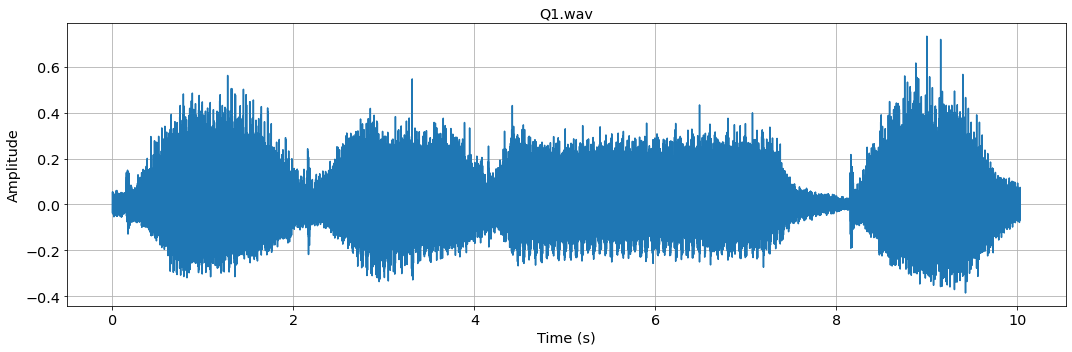

In [ ]:
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 5),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
plt.rcParams.update(params)

soundsamples_asAudioSegment = pydub.AudioSegment.from_file("Q1.wav", format="wav")
soundsamples_asAudioSegment = soundsamples_asAudioSegment.set_channels(1) # make single channel
samplerate = soundsamples_asAudioSegment.frame_rate # get sample rate
numsamples = soundsamples_asAudioSegment.frame_count() # get number of samples
# normalize samples to make in range [-1,1]
soundsamples = np.divide(soundsamples_asAudioSegment.get_array_of_samples(), 
                         soundsamples_asAudioSegment.max_possible_amplitude)

fig, ax = plt.subplots()
plt.plot(np.arange(numsamples)/samplerate, soundsamples)
ax.set_title('Q1.wav')
ax.set_ylabel('Amplitude')
ax.set_xlabel('Time (s)')
fig.tight_layout()
plt.grid()

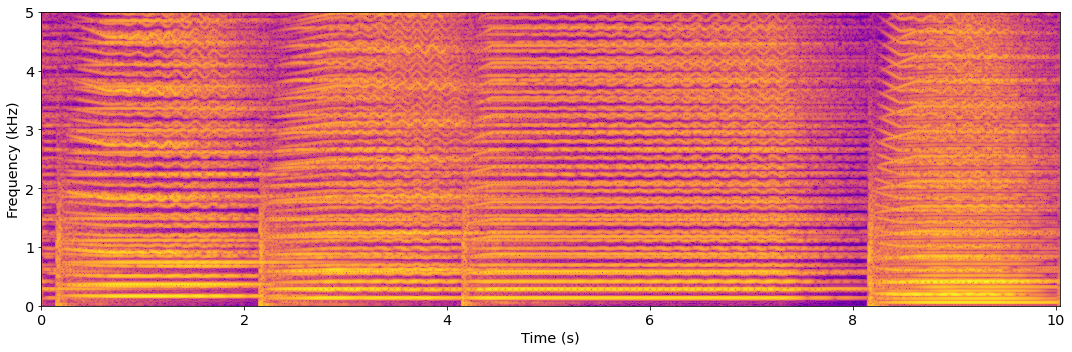

In [ ]:
windowsizeinseconds = 50/1000.0     #50ms duration
windowhopsizeinseconds = 10/1000.0  #10ms hop size
windowoverlapinseconds = windowsizeinseconds - windowhopsizeinseconds

windowsizeinsamples = np.ceil(windowsizeinseconds*samplerate)
windowoverlapinsamples = np.ceil(windowoverlapinseconds*samplerate)

f, t, Zxx = signal.stft(soundsamples,window='hann', nfft=8192,
                                     nperseg=windowsizeinsamples,
                                     noverlap=windowoverlapinsamples)

soundsamplesSTFTindB = 20*np.log10(np.abs(Zxx)/np.max(np.abs(Zxx)))

fig, ax = plt.subplots()
plt.pcolormesh(t/samplerate, f*samplerate/1000, soundsamplesSTFTindB, 
               vmin=-100, vmax=0, cmap='plasma')
ax.set_ylabel('Frequency (kHz)')
ax.set_xlabel('Time (s)')
ax.set_ylim(bottom=0, top=5)
fig.tight_layout()

# Anchor computation

We are now going to locate in this sonogram "anchors", or points of interest. We will take a rather naive approach: for each continguous ΔTxΔF box, find the time and frequency with the largest energy. Let's make ΔT=100 ms, and ΔF be such that it divides the whole spectrum $[0,F_s/2]$ into 25 bands. For each one of these segments, locate the time and frequency of the largest value, as well as its dB. Do this for the sonogram you created in the last question.


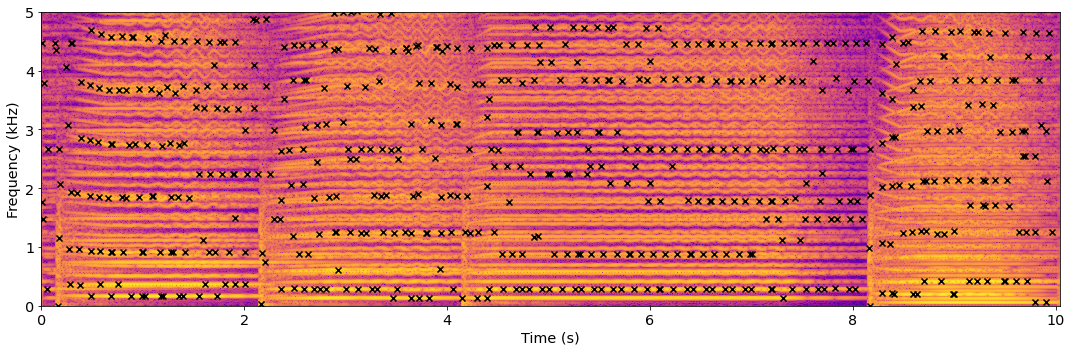

In [ ]:
n_bands = 25
delta_t = 10 #100ms but in cs because t.size is in cs

anchors = []

fig, ax = plt.subplots()
plt.pcolormesh(t/samplerate, f*samplerate/1000, soundsamplesSTFTindB, 
               vmin=-100, vmax=0, cmap='plasma')


for i in range(n_bands):     #the 25 bands in f
  for j in range(t.size//delta_t):  #all the delta_t size slots in the time axis
    starting_point = [i*(f.size//25), j*(t.size//100)] #bottom left corner of the box
    max_coor = starting_point
    max_value = soundsamplesSTFTindB[starting_point[0], starting_point[1]]

    #iterate inside the box and find local maxima
    for k in range(f.size//25):
      for l in range(delta_t):
        
        if(max_value < soundsamplesSTFTindB[starting_point[0] + k, starting_point[1] + l]):
          max_value = soundsamplesSTFTindB[starting_point[0] + k, starting_point[1] + l]
          max_coor = [starting_point[0] + k, starting_point[1] + l]
    
    #plot maximum found inside the box
    plt.scatter(t[max_coor[1]]/samplerate, f[max_coor[0]]*samplerate/1000, marker="x", c="black")
    anchors.append([t[max_coor[1]]/samplerate, f[max_coor[0]]*samplerate/1000])

ax.set_ylabel('Frequency (kHz)')
ax.set_xlabel('Time (s)')
ax.set_ylim(bottom=0, top=5)
fig.tight_layout()

Once we have computed the anchors we can get rid of the STFT and work only with the constellation map which makes for a more efficient computation.

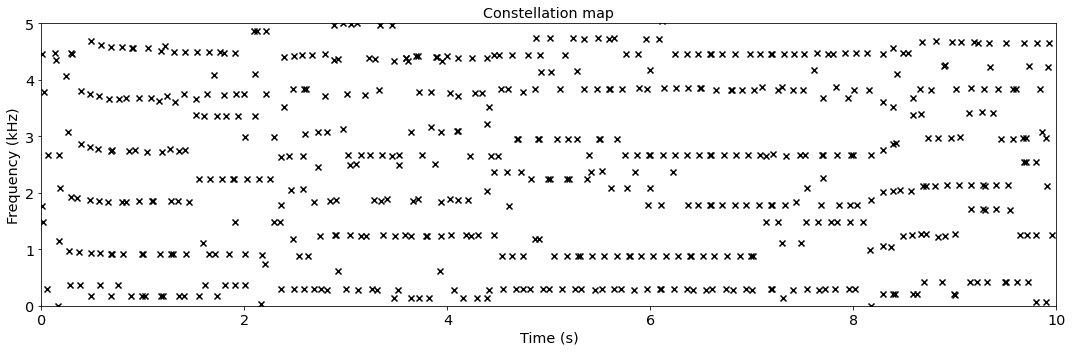

In [ ]:
fig, ax = plt.subplots()

for anchor in anchors:
  plt.scatter(anchor[0], anchor[1], marker="x", c="black")

plt.title("Constellation map")
ax.set_ylabel('Frequency (kHz)')
ax.set_xlabel('Time (s)')
ax.set_xlim(left=0, right=10)
ax.set_ylim(bottom=0, top=5)
fig.tight_layout()

## Hash computation

Now it's time to compute hashes from a set of anchors. A *hash* is a tuple describing an anchor at time ($t_1$) and its relationship to another anchor at time ($t_2$). A Shazam hash is the tuple $(f_1,f_2,∆t_{12})$, which contains the frequencies of both anchors ($f_1$,$f_2$), and the difference in their time positions ($∆t_{12} = t_2-t_1$). The Shazam fingerprint of an audio signal is then the set of hashes extracted from it as well as times at which each hash appears. To create these hashes, Shazam does not look at all pairs of anchors. For a given anchor, it computes hashes using anchors in a "target zone". Define the target zone of an anchor as a time-frequency region 100 ms after $t_1$, spanning 500 ms, and spanning frequencies one half-octave above and below $f_1$. For instance, for an anchor with $t_1$ and $f_1$, its target zone is located between $t_1+100$ ms and $t_1+100+500$ ms, and spans a frequency range of $f_12^{-0.5}$ and $f_12^{0.5}$. Compute all the hashes for your choosen query signal, in the form $(f_1,f_2,∆t_{12})$. Your final data structure representing a fingerprint $F$ should be something like a sequence of times paired with hashes $F = ((\tau_1, h_1), (\tau_2, h_2), \ldots)$, where $\tau_1$ is the time at which hash $h_1$ occurs, etc.

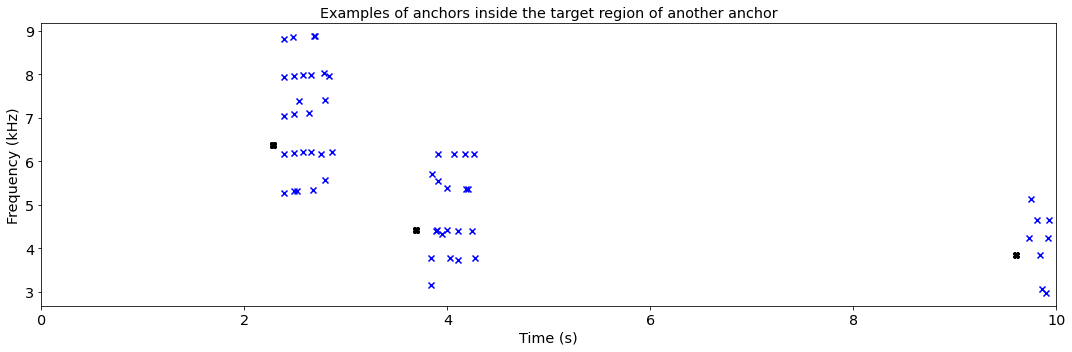

In [ ]:
fig, ax = plt.subplots()

#select three random anchors and compute the anchors in their target zone
randomlist = []
for i in range(3):
  randomlist.append(random.randint(1, 1000))
for i in randomlist:
  anchor = anchors[i]

  for target in anchors:
    if(target[0] > anchor[0]+0.1 and target[0] < anchor[0] + 0.6 and target[1] > anchor[1]/sqrt(2) and target[1] < anchor[1]*sqrt(2)):
      plt.scatter(anchor[0], anchor[1], marker="X", c="black")
      plt.scatter(target[0], target[1], marker="x", c="blue")

plt.title("Examples of anchors inside the target region of another anchor")
ax.set_ylabel('Frequency (kHz)')
ax.set_xlabel('Time (s)')
ax.set_xlim(left=0, right=10)
fig.tight_layout()

In [ ]:
hashes = []

for anchor in anchors:
  for target in anchors:
    if(target[0] > anchor[0]+0.1 and 
       target[0] < anchor[0] + 0.6 and 
       target[1] > anchor[1]/sqrt(2) and 
       target[1] < anchor[1]*sqrt(2)):
      hashes.append([anchor[0], anchor[1], target[1], target[0]-anchor[0]])

# Comparing fingerprints

Now it's time to create an algorithm for comparing two fingerprints. We will start simple to make sure things work. We extract any 1-second segment from the audiofile we worked with above and compute its fingerprint $F_q$ as above. ("q" is for "query".) Now for each hash in $F_q$, find all matching hashes in $F_q$, and store the times of the matches. To compare two hashes, compute the sum of the magnitude differences between the dimensions of the hashes. For instance, if I have these hashes, $(a,b,c)$ and $(d,e,f)$, I just compute the following value: $d = |(a-d)|+|(b-e)|+|(c-f)|$. If $d=0$ then it's a match! Create a scatter plot of the times of the matching hashes.



> We take a 1s excerpt from 6-7s

In [ ]:
soundsamples_asAudioSegment = pydub.AudioSegment.from_file("Q1.wav", format="wav")
soundsamples_asAudioSegment = soundsamples_asAudioSegment.set_channels(1) # make single channel
samplerate = soundsamples_asAudioSegment.frame_rate # get sample rate
numsamples = soundsamples_asAudioSegment.frame_count() # get number of samples
# normalize samples to make in range [-1,1]
soundsamples = np.divide(soundsamples_asAudioSegment.get_array_of_samples(), 
                         soundsamples_asAudioSegment.max_possible_amplitude)

#take 1s from 6-7s
soundsamples = soundsamples[6*samplerate:7*samplerate]

windowsizeinseconds = 50/1000.0     #50ms duration
windowhopsizeinseconds = 10/1000.0  #10ms hop size
windowoverlapinseconds = windowsizeinseconds - windowhopsizeinseconds

windowsizeinsamples = np.ceil(windowsizeinseconds*samplerate)
windowoverlapinsamples = np.ceil(windowoverlapinseconds*samplerate)

f, t, Zxx = signal.stft(soundsamples,window='hann', nfft=8192,
                                     nperseg=windowsizeinsamples,
                                     noverlap=windowoverlapinsamples)

segment = 20*np.log10(np.abs(Zxx)/np.max(np.abs(Zxx)))

In [ ]:
n_bands = 25
delta_t = 10 #100ms but in cs because t.size is in cs

anchors_segment = []

for i in range(n_bands):     #the 25 bands in f
  for j in range(t.size//delta_t):  #all the delta_t size slots in the time axis
    starting_point = [i*(f.size//25), j*(t.size//10)] #bottom left corner of the box
    max_coor = starting_point
    max_value = segment[starting_point[0], starting_point[1]]

    #iterate inside the box and find local maxima
    for k in range(f.size//25):
      for l in range(delta_t):
        
        if(max_value < segment[starting_point[0] + k, starting_point[1] + l]):
          max_value = segment[starting_point[0] + k, starting_point[1] + l]
          max_coor = [starting_point[0] + k, starting_point[1] + l]
    
    #plot maximum found inside the box
    anchors_segment.append([t[max_coor[1]]/samplerate, f[max_coor[0]]*samplerate/1000])

In [ ]:
hashes_segment = []

for anchor in anchors_segment:
  for target in anchors_segment:
    if(target[0] > anchor[0] + 0.1 and 
       target[0] < anchor[0] + 0.6 and 
       target[1] > anchor[1]/sqrt(2) and 
       target[1] < anchor[1]*sqrt(2)):
      hashes_segment.append([anchor[0], anchor[1], target[1], target[0]-anchor[0]])

In [ ]:
match = []

for hash1 in hashes_segment:
  for hash2 in hashes_segment:
    if(abs(hash1[1] - hash2[1]) + abs(hash1[2] - hash2[2]) + abs(hash1[3] - hash2[3]) == 0):
      match.append([hash1[0], hash2[0]])

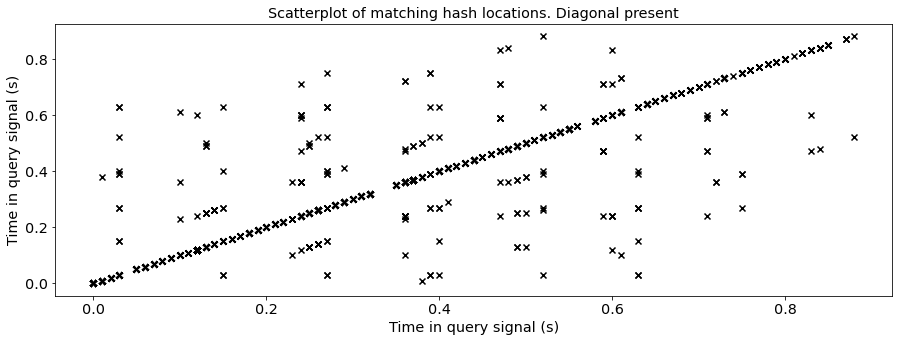

In [ ]:
plt.scatter([item[0] for item in match], [item[1] for item in match], marker="x", c="black")
plt.title('Scatterplot of matching hash locations. Diagonal present')
plt.xlabel('Time in query signal (s)')
plt.ylabel('Time in query signal (s)')
plt.show()

## Comparing fingerprint with the whole audiofile

Now compare $F_q$ with $F_d$, where $F_d$ is the fingerprint of the original audiofile. ("d" is for "document") Again make a scatter plot of the times of the matches. As above, write something about the results.

In [ ]:
matches = []
matches_pairs = []

for hash1 in hashes:
  for hash2 in hashes_segment:
    if(abs(hash1[1] - hash2[1]) + abs(hash1[2] - hash2[2]) + abs(hash1[3] - hash2[3]) == 0):
      matches.append(hash1[0])
      matches_pairs.append([hash1[0], hash2[0]])

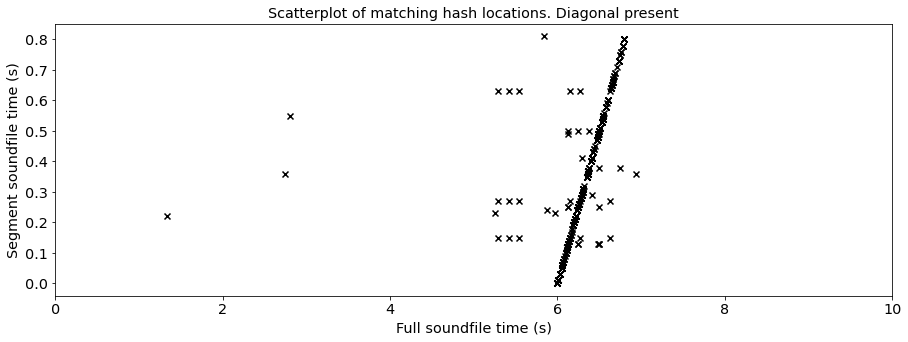

In [ ]:
plt.scatter([item[0] for item in matches_pairs], [item[1] for item in matches_pairs], marker="x", c="black")
plt.xlim(0,10)
plt.title('Scatterplot of matching hash locations. Diagonal present')
plt.xlabel('Full soundfile time (s)')
plt.ylabel('Segment soundfile time (s)')
plt.show()

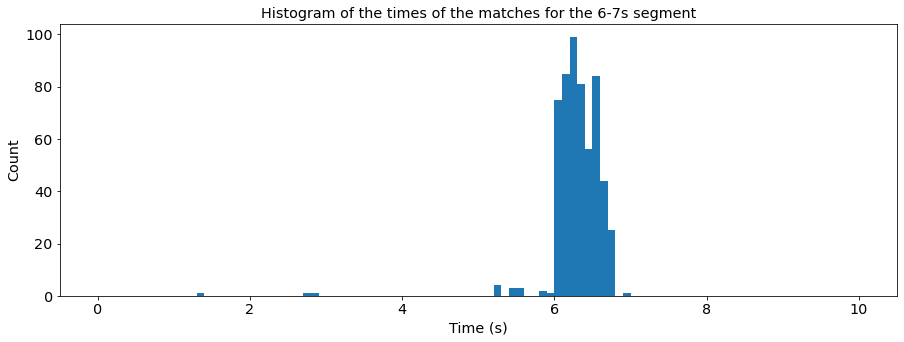

In [ ]:
plt.hist(matches, bins=100, range=[0,10])
plt.title('Histogram of the times of the matches for the 6-7s segment')
plt.xlabel('Time (s)')
plt.ylabel('Count')
plt.show()

### Shazam's weakness

It is worth mentioning that, due to the fingerprinting approach, Shazam only works with perfect matches. Since it does not have any musical understanding of the songs in it's database, a cover song or a humming query would not be correctly labeled.